In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913


/mnt/home/szheng/ceph/envs/ssm/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [5]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

/tmp/ipykernel_257885/3810986821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [6]:
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA

import animate_helper as ah
reload(ah)

<module 'animate_helper' from '/mnt/home/szheng/projects/util_code/animate_helper.py'>

In [7]:
# no speed thresh, get rate map
fr_map_d_run,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=0,speed_key='speed')
fr_map_d_lowsp,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df.query('speed<1'),cell_cols_d['pyr'],speed_thresh=0,nbins=100,smth_in_bin=0,speed_key='speed')




In [8]:
import pca_analysis as pcaa
reload(pcaa)

import surrogate_data as sd

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

In [15]:
# preprocessing
fr_map_trial = fr_map_trial_d[task_ind,tt_ind]
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X = fr_map_trial_centered_normed_df.loc[(slice(None),p),:]
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

In [14]:
pc_df_l,X_reduced_l,exp_var_ratio_l =pcaa.vector_bundle_pca(fr_map_trial_centered_normed_df)

all_corr = pc_df_l.unstack(level=0).corr()

In [13]:
# P = fr_map_trial.shape[1]
# n_eig = pc_df_l.shape[1]

# eig_avail_l=[np.arange(n_eig) for _ in range(P)]

# st_p = 0
# eig_ind_all_p_all_start_eig = []

# for st_eig_ind in range(n_eig):
# # st_eig_ind = 0

#     eig_ind_all_p = []

#     next_p = st_p
#     next_eig_ind = st_eig_ind
#     eig_ind_all_p.append(next_eig_ind)
    
#     index = np.argwhere(eig_avail_l[next_p]==next_eig_ind)
#     eig_avail_l[next_p] = np.delete(eig_avail_l[next_p],index)
    
    
#     for next_p in range(st_p,P-1):
#         all_corr.loc[next_eig_ind,next_p]
#         next_eig_ind_next = all_corr.loc[(next_eig_ind,next_p),(slice(None),next_p+1)].loc[eig_avail_l[next_p+1]].idxmax()[0]
#         index = np.argwhere(eig_avail_l[next_p+1]==next_eig_ind_next)
#         next_eig_ind = next_eig_ind_next
#         eig_avail_l[next_p+1] = np.delete(eig_avail_l[next_p+1], index)
#         eig_ind_all_p.append(next_eig_ind)
#     eig_ind_all_p = pd.Series(eig_ind_all_p)
#     eig_ind_all_p_all_start_eig.append(eig_ind_all_p)
# 
# eig_ind_all_p_all_start_eig = pd.DataFrame(eig_ind_all_p_all_start_eig)

In [13]:
reload(pcaa)
p =0
eig_ind = 0
X = fr_map_trial_centered_normed_df.loc[(slice(None),p),:]
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)
h = X_reduced_l.loc[(p,slice(None)),eig_ind].values[None,:]
lam = 20.#50.
h_l_init = X_reduced_l.loc[:,eig_ind].unstack(level=1).values[:,None,:]
w_l_init = pc_df_l.loc[:,eig_ind].unstack(level=1).values[:,:,None]

NameError: name 'X_reduced_l' is not defined

In [14]:
reload(pcaa)

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

In [15]:
pos_mask = np.ones(100).astype(bool)
pos_mask[0] = False
w_l_allfac,h_l_allfac=pcaa.init_w_l_h_l(fr_map_trial_centered_normed_df,X_l,pos_mask=pos_mask)

In [235]:
reload(pcaa)
n_p = X_l.shape[0]
pos_mask = pcaa.get_pos_mask(n_p,ratio_consec_bins_to_mask=0.1)
w_l, h_l, l_all_l, l_recon_l, l_reg_l = \
pcaa.train_one_factor(X_l,lam=20.,max_iters = 100,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,eig_ind=0,w_l_init=None,h_l_init=None,
                      pos_mask = pos_mask
                     )
r2_total, r2_l = pcaa.get_var_explained_ratio(X_l,w_l,h_l,pos_mask=~pos_mask)


In [150]:
reload(pcaa)

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


<AxesSubplot:>

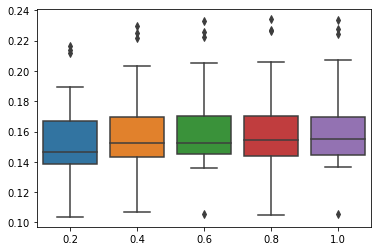

In [244]:
lam_l = [0.2,0.4,0.6,0.8,1.]
cv_res = pcaa.cv_one_factor(X_l,lam_l=lam_l,n_cv=20,ratio_consec_bins_to_mask=0.1,
                    max_iters = 100, stop_thresh = 0.0001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,eig_ind=0,w_l_init=None,h_l_init=None,
    )
sns.boxplot(data=cv_res.loc[(slice(None),'test'),:])

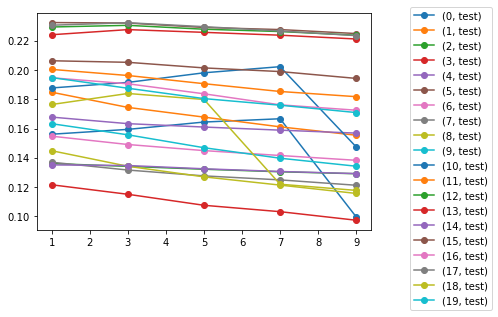

In [242]:
cv_res.loc[(slice(None),'test'),:].T.plot(marker='o')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [22]:
reload(pcaa)
lam_l = [0.5,1.,2.]
n_fac = 3
cv_res = pcaa.cv_all_factor(X_l,n_fac=n_fac,lam_l=lam_l,n_cv=10,ratio_consec_bins_to_mask=0.1,
                    max_iters = 200, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,)



100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


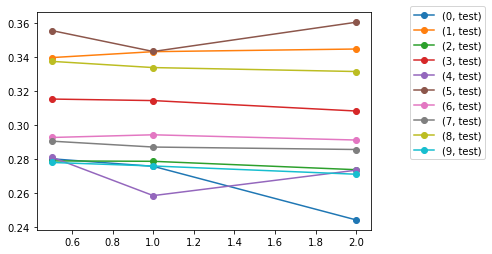

In [23]:
%matplotlib inline
cv_res.loc[(slice(None),'test'),:].T.plot(marker='o')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [235]:
reload(pcaa)
pos_mask = None#pcaa.get_pos_mask(100,ratio_consec_bins_to_mask=0.1)
w_l, h_l, l_all_l, l_recon_l, l_reg_l,w_l_init,h_l_init = pcaa.train_one_factor(X_l,lam=0.001,max_iters = 200, stop_thresh = 0.00001, \
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,eig_ind=0,w_l_init=None,h_l_init=None,return_init=True,
                                                                                pos_mask=pos_mask
                                                                               )



In [236]:
w_l_corr=pd.DataFrame(w_l[:,:,0]).T.corr()
w_l_corr_init=pd.DataFrame(w_l_init[:,:,0]).T.corr()

In [237]:
len(l_all_l)

133

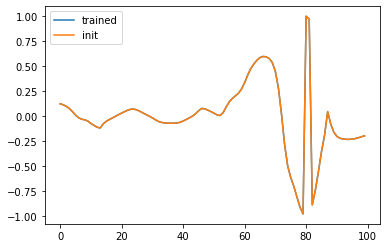

In [238]:
p=80
w_l_corr.loc[p].plot(label='trained')
w_l_corr_init.loc[p].plot(label='init')
plt.legend()

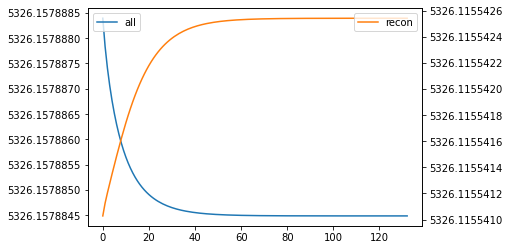

In [239]:
%matplotlib inline
fig,ax=plt.subplots()
ax.ticklabel_format(useOffset=False)
ax.plot(l_all_l,label='all')
ax2=ax.twinx()
ax2.plot(l_recon_l,color='C1',label='recon')
ax2.ticklabel_format(useOffset=False)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


In [219]:
np.linalg.norm(w_l[3])

1.0

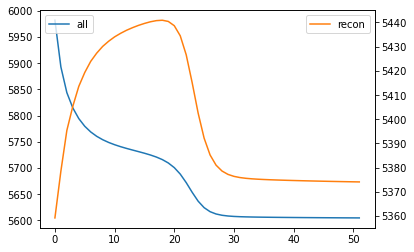

In [229]:
%matplotlib inline
fig,ax=plt.subplots()
ax.ticklabel_format(useOffset=False)
ax.plot(l_all_l,label='all')
ax2=ax.twinx()
ax2.plot(l_recon_l,color='C1',label='recon')
ax2.ticklabel_format(useOffset=False)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


In [23]:
# low lam
reload(pcaa)
w_l_allfac_fit, h_l_allfac_fit,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac = \
    pcaa.train_all_factor(X_l,n_fac=3,lam=1.,max_iters = 200, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
                    pos_mask = None,return_init=True)


#high lam
reload(pcaa)
w_l_allfac_fit_highlam, h_l_allfac_fit_highlam,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac = \
    pcaa.train_all_factor(X_l,n_fac=3,lam=20.,max_iters = 200, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
                    pos_mask = None,return_init=True)


In [25]:
pcaa.get_var_explained_ratio(X_l,w_l_allfac_fit_highlam[:,:,[1]], h_l_allfac_fit_highlam[:,[1],:])

(0.11506873062322076,
 array([0.11403769, 0.15193789, 0.16414688, 0.16596269, 0.16230323,
        0.15475503, 0.1448072 , 0.13375766, 0.12200215, 0.11127117,
        0.10834182, 0.11990369, 0.14168452, 0.15447107, 0.14318588,
        0.12283946, 0.11096063, 0.10996056, 0.11145608, 0.11237113,
        0.11694399, 0.12415459, 0.12660542, 0.11709307, 0.09995725,
        0.09847741, 0.10690587, 0.1047205 , 0.09956784, 0.09914932,
        0.09928205, 0.09736189, 0.09479966, 0.09470108, 0.09987889,
        0.10926028, 0.11932748, 0.12700095, 0.1290596 , 0.11934397,
        0.09717474, 0.07779086, 0.07340224, 0.07790591, 0.081696  ,
        0.07372684, 0.06041111, 0.06443264, 0.07405599, 0.07852296,
        0.08115484, 0.08604079, 0.09203467, 0.09534942, 0.09663099,
        0.10090236, 0.10811679, 0.11604787, 0.12474053, 0.130484  ,
        0.13011834, 0.124247  , 0.11565657, 0.11075826, 0.11376282,
        0.11916676, 0.12213945, 0.12637666, 0.1339156 , 0.14039417,
        0.14123916, 0.1379

In [267]:
pcaa.get_var_explained_ratio(X_l,w_l_allfac_fit_highlam[:,:,[1]], h_l_allfac_fit_highlam[:,[1],:])

(0.11679003208526817,
 array([0.11472792, 0.15226513, 0.16452238, 0.16644922, 0.16288791,
        0.15560496, 0.14617396, 0.13569775, 0.12417536, 0.11331428,
        0.110949  , 0.12354584, 0.14465931, 0.15645109, 0.14539922,
        0.12299573, 0.10981496, 0.1096092 , 0.11160782, 0.11249283,
        0.11698963, 0.12420188, 0.1267063 , 0.11727077, 0.10016775,
        0.0987086 , 0.10715776, 0.10483988, 0.09923132, 0.09872209,
        0.09923967, 0.09750214, 0.09493091, 0.09496313, 0.10018158,
        0.10961005, 0.11959642, 0.12697647, 0.12870766, 0.11835498,
        0.09542212, 0.07749773, 0.07691983, 0.08428164, 0.08991677,
        0.08561208, 0.07769191, 0.07583078, 0.07712771, 0.0800732 ,
        0.08522259, 0.09310315, 0.10063318, 0.10356369, 0.10339673,
        0.10543837, 0.10984914, 0.11656805, 0.12567732, 0.13176045,
        0.13091655, 0.12419825, 0.11524484, 0.11052167, 0.11370048,
        0.11913047, 0.12213479, 0.12645495, 0.13403318, 0.14045825,
        0.14122963, 0.1380

In [26]:
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False

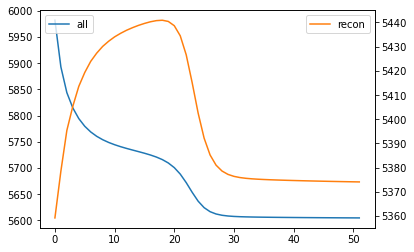

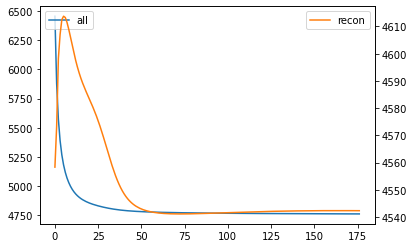

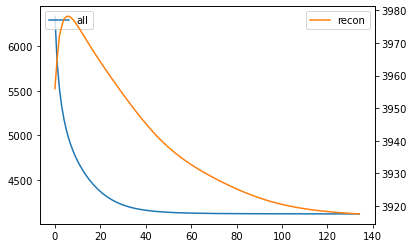

In [26]:
%matplotlib inline
for ee in range(len(l_all_allfac)):
    l_all_l = l_all_allfac[ee]
    l_recon_l = l_recon_allfac[ee]
    fig,ax=plt.subplots()
    ax.ticklabel_format(useOffset=False)
    ax.plot(l_all_l,label='all')
    ax2=ax.twinx()
    ax2.plot(l_recon_l,color='C1',label='recon')
    ax2.ticklabel_format(useOffset=False)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


In [43]:
tt=0
h_1trial=h_l_allfac_fit_highlam[:,:2,tt]#h_l_allfac_fit[:,:2,tt]
h_1trial_pos = np.concatenate([np.arange(100)[:,None],h_1trial],axis=1)

In [53]:
import matplotlib
import matplotlib.cm as cm

In [88]:
pos_l.shape

(1, 1, 3300)

In [89]:
pos_l = np.arange(h_l_allfac_fit_highlam.shape[0])
pos_l=np.tile(pos_l[:,None,None],[1,1,h_l_allfac_fit_highlam.shape[-1]])
h_l_pos = np.concatenate([pos_l,h_l_allfac_fit_highlam],axis=1)

h_one_trial_df_l = []
for tt in range(h_l_pos.shape[-1]):
    npcs = h_l_pos.shape[1] - 1
    columns = ['pos'] + [f'pc{nn}' for nn in range(npcs)]
    h_one_trial_df = pd.DataFrame(h_l_pos[:,:,tt],columns=columns)
    h_one_trial_df['trial'] = tt
    h_one_trial_df_l.append(h_one_trial_df)
h_one_trial_df_l = pd.concat(h_one_trial_df_l,axis=0,ignore_index=True)


In [96]:
h_one_trial_df_l

,pos,pc1,pc2,pc3,trial
0,0.0,0.979624,0.289758,-0.086803,0
1,1.0,1.055021,0.435592,-0.023703,0
2,2.0,1.036084,0.505436,-0.009047,0
3,3.0,1.026007,0.539436,-0.024522,0
4,4.0,1.040122,0.548437,-0.044749,0
...,...,...,...,...,...
95,95.0,0.515617,0.675126,-0.786263,32
96,96.0,0.709851,0.949568,-0.947205,32
97,97.0,0.868852,1.122748,-1.022035,32
98,98.0,0.952726,1.158732,-0.953265,32


<IPython.core.display.Javascript object>


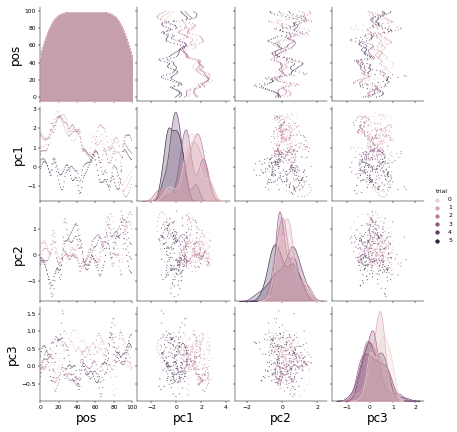

In [107]:
toplot = h_one_trial_df_l.query('trial<=5')
g=sns.pairplot(data=toplot,hue='trial',plot_kws={"s": 3})
for axii in range(len(g.axes[:,0])):
    g.axes[axii,0].set_xlim([0,100])
g

<IPython.core.display.Javascript object>


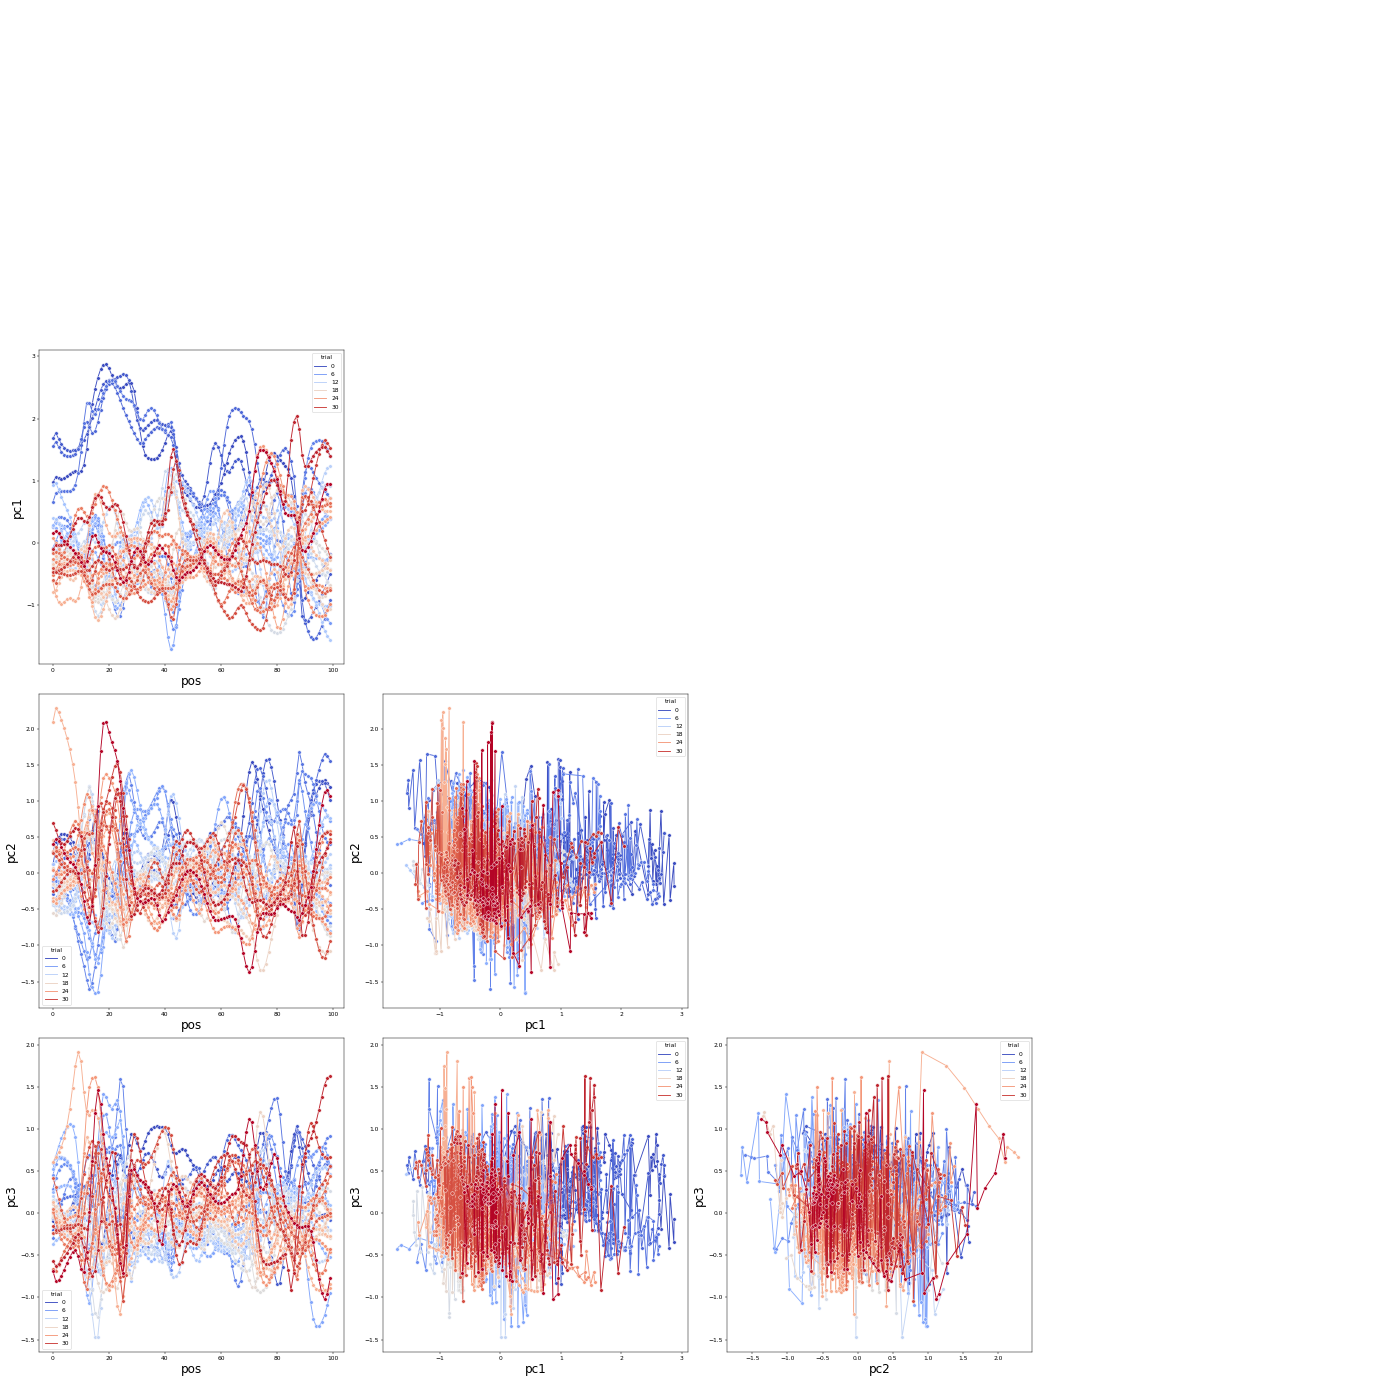

In [260]:
%matplotlib notebook
toplot = h_one_trial_df_l.query('trial<=33')
# toplot = h_one_trial_df_l.query('25>=trial>=15')
nplots=h_one_trial_df_l.shape[1]-1
fig,axs=plt.subplots(nplots,nplots,figsize=(nplots*8,nplots*8))
cols = h_one_trial_df_l.columns[:nplots]
for jj in range(nplots):
    for ii in range(nplots):
        if ii > jj:
            if cols[jj]=='pos':
                sns.lineplot(data=toplot,x=cols[jj],y=cols[ii],hue='trial',marker='o',palette='coolwarm',ax=axs[ii,jj])
            else:
                sns.lineplot(data=toplot,x=cols[jj],y=cols[ii],hue='trial',marker='o',palette='coolwarm',ax=axs[ii,jj])
        else:
            axs[ii,jj].axis('off')
plt.tight_layout()

<IPython.core.display.Javascript object>


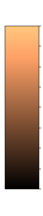

In [149]:
tt=5
trial_l = range(tt)#range(X_l.shape[2])
minima = min(trial_l)
maxima = max(trial_l)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
cmap = matplotlib.cm.get_cmap('copper')
fig,ax=plt.subplots(figsize=(1,5))
# fig,axs=plt.subplots(1,2,gridspec_kw={'width_ratios': [10, 1]})
cb = matplotlib.colorbar.ColorbarBase(ax,cmap=cmap,norm=norm)
rgba = [cmap(norm(x)) for x in trial_l]

In [165]:
npos = 100
rgba = [[i]*npos for i in rgba]

import itertools
rgba=list(itertools.chain.from_iterable(rgba))

<IPython.core.display.Javascript object>


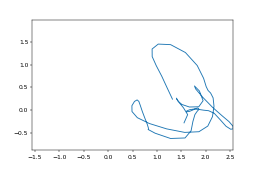

In [169]:
%matplotlib notebook
tt = 2
h_onetrial = h_one_trial_df_l.query('trial==@tt')
data = h_onetrial[['pc1','pc2']].values.T
fig,ax, ani = ah.animate_line(data,legend_handles=None,color_l=rgba,fig=None,ax=None,ax_kws={},animate_kws={},dosave=False)




<IPython.core.display.Javascript object>


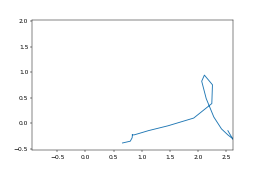

In [170]:
%matplotlib notebook
tt = 3
h_onetrial = h_one_trial_df_l.query('trial==@tt')
data = h_onetrial[['pc1','pc2']].values.T
fig,ax, ani = ah.animate_line(data,legend_handles=None,color_l=rgba,fig=None,ax=None,ax_kws={},animate_kws={},dosave=False)




<IPython.core.display.Javascript object>


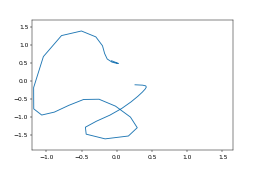

In [171]:
%matplotlib notebook
tt = 4
h_onetrial = h_one_trial_df_l.query('trial==@tt')
data = h_onetrial[['pc1','pc2']].values.T
fig,ax, ani = ah.animate_line(data,legend_handles=None,color_l=rgba,fig=None,ax=None,ax_kws={},animate_kws={},dosave=False)




In [ ]:
import plot_ratemap_sequence as prs

%matplotlib inline
fig,axs = plt.subplots(4,1,sharex=True,sharey=True,figsize=(1*8,4*4))
fr_map_one= fr_map_trial_df_d.loc[task_ind,tt_ind].mean(axis=1).unstack()
fig,ax,order=prs.plot_population_sequence(fr_map_one,normalize=False,fig=fig,ax=axs[0])
for ii in range(w_l_allfac_fit_highlam.shape[-1]):
    w_one = w_l_allfac_fit_highlam[:,:,ii].T
    w_one_df=pd.DataFrame(w_one,index=fr_map_one.index)
    sns.heatmap(data=w_one_df.loc[order],cmap='vlag',center=0,ax=axs[ii+1],cbar=False)

In [285]:
np.einsum('pn,pn->p',w_l_allfac_fit_highlam[:,:,0],w_l_allfac_fit_highlam[:,:,1])

array([-0.04113379, -0.06010709, -0.06521964, -0.0622939 , -0.05045449,
       -0.0315391 , -0.00716433,  0.02540985,  0.07139648,  0.1273216 ,
        0.16821103,  0.15891702,  0.0904424 , -0.01312176, -0.10527078,
       -0.14465937, -0.12574231, -0.07837978, -0.03826141, -0.01635884,
       -0.00771177, -0.00865194, -0.02088601, -0.04350902, -0.05856695,
       -0.03556366,  0.01922297,  0.07153852,  0.10059552,  0.10553101,
        0.09324003,  0.06273354,  0.01855847, -0.01935095, -0.03608325,
       -0.03296425, -0.01901177, -0.00526067, -0.00389962, -0.02142256,
       -0.04879477, -0.0660872 , -0.05918629, -0.02052705,  0.07125495,
        0.23187907,  0.3927816 ,  0.44286256,  0.38877771,  0.29700915,
        0.20156835,  0.11040041,  0.02617136, -0.04512878, -0.09244736,
       -0.10205753, -0.07070137, -0.0162128 ,  0.03622558,  0.07161951,
        0.08528831,  0.0798683 ,  0.06629398,  0.05519591,  0.04750545,
        0.0422483 ,  0.04235619,  0.04810979,  0.0543058 ,  0.05

In [279]:
resid=X_l - np.einsum('pnr,prl->pnl',w_l_allfac_fit_highlam[:,:,[0]],h_l_allfac_fit_highlam[:,[0],:])

In [281]:
np.einsum('pnl,pnr->plr',resid,w_l_allfac_fit_highlam[:,:,[0]])

array([[[-1.36880524e-17],
        [ 1.75114914e-15],
        [ 1.37735689e-15],
        ...,
        [-2.32832417e-16],
        [-1.61546124e-16],
        [-1.78513888e-16]],

       [[-6.70680688e-16],
        [-6.09131886e-16],
        [-9.91394467e-16],
        ...,
        [-2.09782956e-16],
        [-1.08420217e-17],
        [ 1.01535533e-16]],

       [[-8.61251242e-16],
        [ 6.63735017e-16],
        [ 2.18121148e-16],
        ...,
        [-2.56273206e-16],
        [ 8.45813220e-17],
        [-1.85412124e-16]],

       ...,

       [[-3.49113100e-16],
        [ 5.24645431e-16],
        [ 3.03034507e-16],
        ...,
        [ 4.88758339e-16],
        [-9.76215636e-16],
        [-6.28837260e-17]],

       [[ 5.46437895e-17],
        [ 9.07368798e-16],
        [-1.14497170e-15],
        ...,
        [-1.99493200e-15],
        [ 1.41813644e-16],
        [ 8.47629258e-16]],

       [[ 8.61940727e-18],
        [ 2.50775962e-16],
        [ 7.73361410e-16],
        ...,
        

# compare with pca directly on all locations

In [187]:
fr_reshaped_for_pca=fr_map_trial_centered_normed_df.unstack(level=1)
X_reduced,pc_df,pca,n_comp_sufficient = pcaa.do_pca(fr_reshaped_for_pca,var_thresh=0.9,n_comp_default=50) 



In [194]:
pc_df

0         1         2         3         4         5         6   \
0  0   0.022495  0.003117  0.003682 -0.002799  0.007639 -0.000195  0.020736   
   1   0.022310  0.004791  0.004504 -0.002663  0.008523 -0.000416  0.018579   
   2   0.022323  0.007044  0.005563 -0.002359  0.010135 -0.000923  0.015648   
   3   0.022670  0.009474  0.006582 -0.002007  0.012171 -0.001596  0.012449   
   4   0.023379  0.012040  0.007404 -0.001651  0.014417 -0.002276  0.009042   
...         ...       ...       ...       ...       ...       ...       ...   
32 95 -0.013200  0.006304  0.011517  0.008528 -0.016389 -0.019203 -0.024444   
   96 -0.014521  0.007895  0.015819  0.010234 -0.017953 -0.020152 -0.027810   
   97 -0.015499  0.009095  0.018802  0.011465 -0.018980 -0.020791 -0.030269   
   98 -0.016143  0.010485  0.021421  0.012849 -0.020144 -0.021311 -0.032582   
   99 -0.016278  0.011298  0.022479  0.013673 -0.020670 -0.021298 -0.033605   

             7         8         9   ...        40        41        42  \
0  0   0.029276  0.007919 -0.016163  ... -0.010370 -0.000719  0.004295   
   1   0.028380  0.007716 -0.016390  ... -0.006788  0.000380  0.000624   
   2   0.027447  0.007389 -0.016573  ... -0.001309  0.002277 -0.003995   
   3   0.026645  0.007024 -0.016596  ...  0.005168  0.004575 -0.008396   
   4   0.025865  0.006697 -0.016432  ...  0.012323  0.007014 -0.012260   
...         ...       ...       ...  ...       ...       ...       ...   
32 95 -0.024054  0.004807 -0.066274  ...  0.026919  0.048627 -0.018894   
   96 -0.025323  0.004299 -0.079688  ...  0.031206  0.053128 -0.015766   
   97 -0.025906  0.003889 -0.089016  ...  0.034063  0.055368 -0.012617   
   98 -0.025772  0.003999 -0.095947  ...  0.036302  0.057122 -0.009322   
   99 -0.025110  0.003960 -0.097793  ...  0.036843  0.056841 -0.006798   

             43        44        45        46        47        48        49  
0  0   0.011821 -0.005730  0.006476  0.026079 -0.016270 -0.014626 -0.002560  
   1   0.010044 -0.005171  0.006234  0.024043 -0.017641 -0.015711 -0.000594  
   2   0.007683 -0.004332  0.005587  0.021818 -0.019429 -0.016703  0.002103  
   3   0.005361 -0.003417  0.004391  0.020098 -0.021068 -0.017137  0.004816  
   4   0.003334 -0.002498  0.002680  0.019008 -0.022285 -0.016888  0.007327  
...         ...       ...       ...       ...       ...       ...       ...  
32 95  0.021918  0.020613 -0.029233 -0.072196  0.015190 -0.010791  0.018053  
   96  0.026228  0.021586 -0.032934 -0.079470  0.019500 -0.004694  0.023424  
   97  0.029673  0.022028 -0.035201 -0.083371  0.023285  0.000582  0.026829  
   98  0.032024  0.022226 -0.036016 -0.085494  0.026328  0.005383  0.028848  
   99  0.032754  0.021762 -0.035709 -0.084166  0.028244  0.008383  0.028981  

[3300 rows x 50 columns]

In [206]:
npcs = 3
h_l_pos_pca = pc_df.loc[:,0:(npcs-1)].reset_index()
cols = ['trial','pos'] + [f'pc{i}' for i in range(npcs)]
h_l_pos_pca.columns = cols
cols = cols[1:]+cols[:1]
h_l_pos_pca = h_l_pos_pca.loc[:,cols]



In [207]:
h_l_pos_pca

,pos,pc0,pc1,pc2,trial
0,0,0.022495,0.003117,0.003682,0
1,1,0.022310,0.004791,0.004504,0
2,2,0.022323,0.007044,0.005563,0
3,3,0.022670,0.009474,0.006582,0
4,4,0.023379,0.012040,0.007404,0
...,...,...,...,...,...
3295,95,-0.013200,0.006304,0.011517,32
3296,96,-0.014521,0.007895,0.015819,32
3297,97,-0.015499,0.009095,0.018802,32
3298,98,-0.016143,0.010485,0.021421,32


In [262]:
pca.explained_variance_ratio_

array([0.06783896, 0.053914  , 0.04442795, 0.04304942, 0.0330508 ,
       0.03207086, 0.02985577, 0.02579896, 0.02436027, 0.02243831,
       0.02139975, 0.01967644, 0.01768878, 0.01615064, 0.01511253,
       0.01443895, 0.01379735, 0.01327209, 0.01277291, 0.01229297,
       0.01162884, 0.01101952, 0.01043454, 0.01016771, 0.0097079 ,
       0.00965415, 0.00899115, 0.00887469, 0.00857458, 0.00834296,
       0.00818503, 0.00797026, 0.0077537 , 0.00716008, 0.00689357,
       0.00662118, 0.00660869, 0.00634528, 0.00630037, 0.00619672,
       0.00602064, 0.0060028 , 0.0058303 , 0.00561866, 0.00542742,
       0.00532697, 0.00503832, 0.00488801, 0.00479172, 0.00470787])

<IPython.core.display.Javascript object>


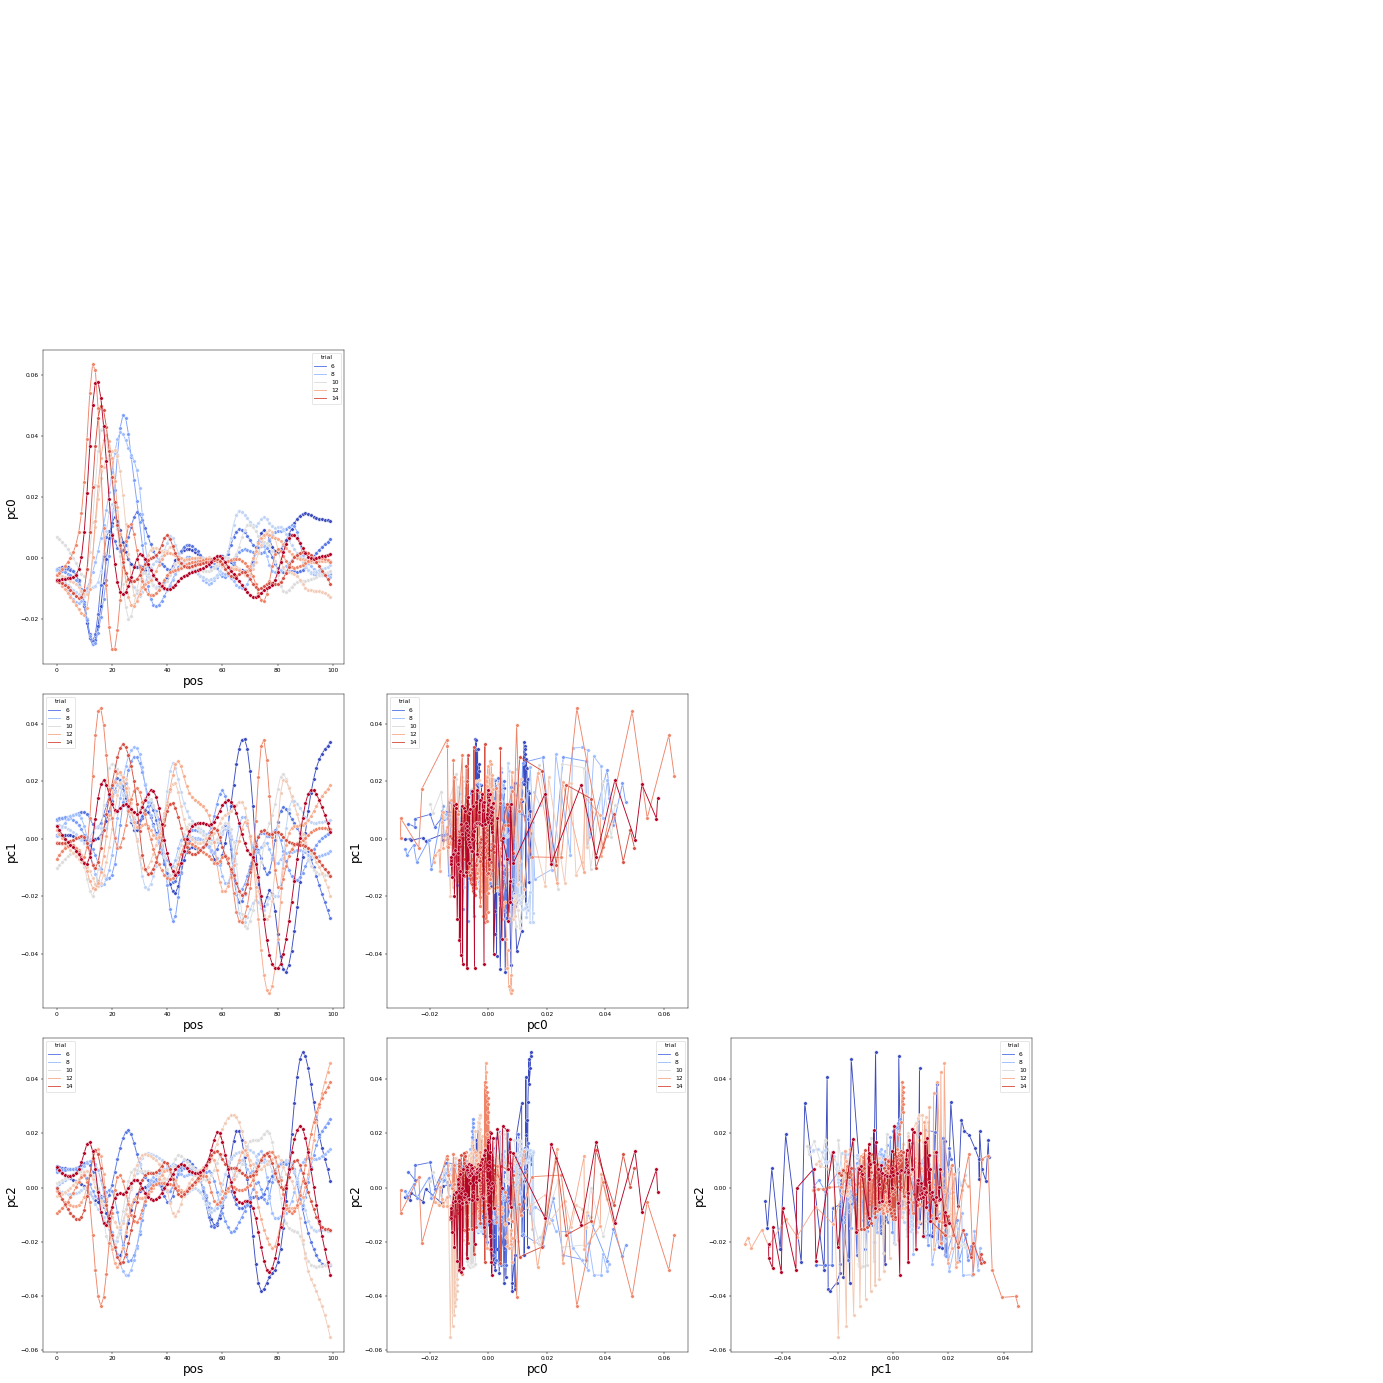

In [269]:
%matplotlib notebook
toplot = h_l_pos_pca.query('15>=trial>=5')
# toplot = h_l_pos_pca.query('35>=trial')
nplots=toplot.shape[1]-1
fig,axs=plt.subplots(nplots,nplots,figsize=(nplots*8,nplots*8))
cols = toplot.columns[:nplots]
for jj in range(nplots):
    for ii in range(nplots):
        if ii > jj:
            if cols[jj]=='pos':
                sns.lineplot(data=toplot,x=cols[jj],y=cols[ii],hue='trial',marker='o',palette='coolwarm',ax=axs[ii,jj])
            else:
                sns.lineplot(data=toplot,x=cols[jj],y=cols[ii],hue='trial',marker='o',palette='coolwarm',ax=axs[ii,jj])
        else:
            axs[ii,jj].axis('off')
plt.tight_layout()

In [252]:
X_reduced

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1.0,-0.092637,0.116756,0.011113,-0.075163,-0.061458,0.055168,0.048430,-0.043531,-0.078147,0.035802,...,0.025616,0.007254,-0.018515,-0.015822,0.020621,0.001530,0.004480,-0.001897,0.027222,0.005781
2.0,-0.094086,0.106166,0.003250,-0.062385,-0.047664,0.034770,0.047247,-0.030802,-0.056694,0.015062,...,0.012581,-0.000728,-0.011727,-0.018961,0.017948,0.011130,-0.004770,-0.007240,0.032577,-0.002946
3.0,-0.463422,0.111050,0.027285,0.159082,0.056590,0.140794,0.001252,-0.050255,-0.236146,-0.094513,...,-0.003289,-0.001150,0.042158,0.031248,0.333672,0.022583,0.024884,0.039838,0.047776,-0.149056
27.0,1.261766,0.091235,1.453760,0.104767,0.368540,-0.779593,0.316671,1.010702,1.039524,2.726021,...,-0.701966,0.114886,-0.498500,0.480848,0.079268,0.368343,-0.422354,-0.301387,0.436959,-0.623247
29.0,-4.473645,0.719627,0.061192,6.525362,2.530141,1.156784,1.777460,-0.092150,0.615288,-1.259471,...,0.038952,0.748408,-0.155890,-0.594537,-0.234414,0.072609,0.045561,-0.612007,-0.626258,0.862946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476.0,-0.464191,-0.494793,0.475326,-0.825548,0.211459,-0.289705,-0.508702,-0.398968,0.026381,0.060583,...,0.312371,-0.109350,-0.251615,0.095978,-0.349987,0.006167,-0.226185,0.257517,-0.179416,0.248884
477.0,-0.100782,0.110567,0.000040,-0.053546,-0.043414,0.031819,0.043913,-0.041036,-0.074936,0.003402,...,-0.001091,-0.006270,-0.013831,-0.014229,0.021620,0.007163,-0.007875,-0.001413,0.028448,-0.017960
478.0,-0.022473,0.131370,0.127530,-0.067726,0.035578,0.113774,0.035092,0.016012,-0.077510,-0.161239,...,-0.111143,0.123608,-0.015798,0.002037,-0.076796,0.034674,0.111186,0.057029,0.055962,-0.042841
479.0,-0.096323,0.138064,-0.013974,-0.135278,-0.114777,0.045713,0.076718,0.055596,-0.146186,0.009565,...,0.033466,-0.054899,-0.038453,0.005605,0.001638,-0.035993,-0.030254,-0.000150,0.030397,-0.098754


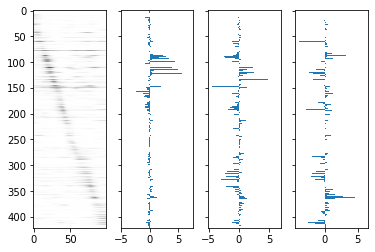

In [255]:
fig,axs=plt.subplots(1,4,sharey=True)
fig,ax,order=prs.plot_population_sequence(fr_map_one,normalize=False,fig=fig,ax=axs[0])
for i in range(0,3):
    w_one = X_reduced[i]
    axs[i+1].barh(np.arange(w_one.shape[0]),w_one.loc[order])

In [ ]:
X_reduced

In [176]:
X_l.shape

(100, 422, 33)